In [28]:
import tellurium as te
import roadrunner
import antimony 
import numpy as np
import matplotlib.pylab as plt

In [29]:
model = ("""
model Cybergenetic_Feedback_Burden_Control

/* This model uses concentration and time units of number of molecules and min */

//Core Weisse Model
    //Reactions
        #Nutrient import & metabolism
        n1: s -> s_i; v_imp;      ## nutrient (s) import
        n2: s_i -> ; lmda * s_i;  ## nutrient dilution due to growth (lmda)
        n3: s_i -> a; v_cat;      ## nutrient metabolism to produce energy (a)  ## nutrient efficiency n_s = 1
        n4: a -> ; lmda * a;      ## energy dilution due to growth (lmda)
        
        #Transcription & mRNA degradation
        tx1: -> m_r; w_r;                  ## ribosome mRNA transcription
        tx2: m_r -> ; (lmda + d_m) * m_r;  ## ribosome mRNA dilution due to growth (lmda) and degradation (d_m)
        tx3: -> m_t; w_t;                  ## transporter enzyme mRNA transcription
        tx4: m_t -> ; (lmda + d_m) * m_t;  ## transporter enzyme mRNA dilution and degradation
        tx5: -> m_m; w_m;                  ## metabolic enzyme mRNA transcription
        tx6: m_m -> ; (lmda + d_m) * m_m;  ## metabolic enzyme mRNA dilution and degradation
        tx7: -> m_q; w_q;                  ## house keeping proteins mRNA transcription
        tx8: m_q -> ; (lmda + d_m) * m_q;  ## house keeping proteins mRNA dilution and degradation
        
        #Ribosome binding (ribosome is p_r)
        rb1: m_r + p_r -> c_r; k_b * m_r * p_r;  ## formation of ribosome mRNA-ribosome complex
        rb2: c_r -> m_r + p_r; k_u * c_r;        ## dissociation of ribosome mRNA-ribosome complex
        rb3: c_r -> ; lmda * c_r;                ## dilution of ribosome mRNA-ribosome complex
        rb4: m_t + p_r -> c_t; k_b * m_t * p_r;  ## formation of transporter enzyme mRNA-ribosome complex
        rb5: c_t -> m_t + p_r; k_u * c_t;        ## dissociation of transporter enzyme mRNA-ribosome complex
        rb6: c_t -> ; lmda * c_t;                ## dilution of of transporter enzyme mRNA-ribosome complex
        rb7: m_m + p_r -> c_m; k_b * m_m * p_r;  ## formation of metabolic enzyme mRNA-ribosome complex
        rb8: c_m -> m_m + p_r; k_u * c_m;        ## dissociation of metabolic enzyme mRNA-ribosome complex
        rb9: c_m -> ; lmda * c_m;                ## dilution of metabolic enzyme mRNA-ribosome complex
        rb10: m_q + p_r -> c_q; k_b * m_q * p_r; ## formation of house keeping proteins mRNA-ribosome complex
        rb11: c_q -> m_q + p_r; k_u * c_q;       ## dissociation of house keeping proteins mRNA-ribosome complex
        rb12: c_q -> ; lmda * c_q;               ## dilution of house keeping proteins mRNA-ribosome complex
        
        #Translation & protein dilution
        tl1: 7459 a + c_r -> 2 p_r + m_r; v_r;    ## tranlsation of ribosome  ## ribosome length n_r = 7459 aa
        tl2: p_r -> ; lmda * p_r;                 ## dilution of ribosome
        tl3: 300 a + c_t -> p_t + m_t + p_r; v_t; ## tranlsation of transporter enzyme  ## protein length = 300 aa
        tl4: p_t -> ; lmda * p_t;                 ## dilution of transporter enzyme
        tl5: 300 a + c_m -> p_m + m_m + p_r; v_m; ## tranlsation of metabolic enzyme  ## protein length = 300 aa
        tl6: p_m -> ; lmda * p_m;                 ## dilution of metabolic enzyme
        tl7: 300 a + c_q -> p_q + m_q + p_r; v_q; ## tranlsation of house keeping proteins  ## protein length = 300 aa
        tl8: p_q -> ; lmda * p_q;                 ## dilution of house keeping proteins
        
        #Cell population growth
         -> N; lmda * N;         ## population growth
        s -> ; v_imp * (N - 1);  ## change in external nutrient due to competition
    
    //Equations
        /* Algebraic relationships and functions are written as Assignement 
        Rules in Antimony. */
    
        #Growth  ## cell growth rate is proportional to rate of protein synthesis (c_tot)
        lmda := (gmma / M) * (c_tot);  ## M = mass of a mid log cell, c_tot = number of translating ribosomes
        gmma := gmma_max * a / (K_gmma + a);  ## gmma = rate of translational elongation, 
                                              ## gmma_max = maximal translation rate, K_gmma = half maximal elongation
                                              ## translation rate is dependent on energy
                        
        c_tot := c_r + c_t + c_m + c_q + c_add ## c_tot = number of translating ribosomes
                                               ## c_add represents expression of additional proteins to be factored into growth rate
    
        #Import & metabolism
        v_imp := p_t * (mu_t * s) / (K_t + s);     ## dependent on transporter enzyme p_t, mu_t = max import rate, K_t = half maximal threshold
        v_cat := p_m * (mu_m * s_i) / (K_m + s_i); ## dependent on metabolic enzyme p_m, mu_m = max metabolism rate, K_m = half maximal threshold
        
        #Transcription  ## all but q proteins have transcription rate solely dependent on energy level a
        w_r := w_rmax * a / (theta_r + a);   ## theta_r = transcriptional threshold for ribosomal genes
        w_t := w_tmax * a / (theta_nr + a);  ## theta_nr = transcriptional threshold for non-ribosomal genes
        w_m := w_mmax * a / (theta_nr + a);  ## w_rmax, w_tmax, w_mmax = max transcription rate - a lumped description of transcription elongation speed
        w_q := w_qmax * a / (theta_nr + a) / (1 + (p_q / K_q) ^ h_q); ## auto-regulated to sustain stable protein levels across different growth conditions
                                                                      ## (1 + (p_q / K_q) ^ h_q) = auto-inhibition function, K_q = threshold, h_q = hill coefficient
                                                                      
        #Translation
        v_r := c_r * gmma / n_r;    ## gmma = rate of translational elongation, n_r = ribosome length 7459 aa
        v_t := c_t * gmma / n_tmq;  ## n_tmq = length of non-ribosomal protein 300 aa
        v_m := c_m * gmma / n_tmq;
        v_q := c_q * gmma / n_tmq;
    
    //Parameters
        /* Parameter values used are the default values from the 
        Weisse model */
    
        #Growth
        M = 1e8;         ## total cell mass = total protein mass = 10^8 aa
        gmma_max = 1260; ## max translational elongation rate = 1260 aa/min molecs
        K_gmma = 7;      ## translational elongation threshold = 7 molecs/cell
        
        #Nutrients
        mu_t = 726; K_t = 1e3;  ## max nutrient import rate = 726 /min, nutrient import threshold = 1000 molecs
        mu_m = 5800; K_m = 1e3; ## max enzymatic rate = 5800 /min, enzymatic threshold = 1000 molecs/cell
        
        #Transcription
        w_rmax = 930;  ## max ribosome transcription rate = 930 molecs/min cell
        w_tmax = 4.14; ## max enzyme transcription rate = 4.14 molecs/min cell
        w_mmax = 4.14; ## max enzyme transcription rate = 4.14 molecs/min cell
        w_qmax = 948.93;  ## max q-transcription rate = 949 molecs/min cell
        theta_r = 426.87; ## ribosome transcription threshold = 427 molecs/cell
        theta_nr = 4.38;  ## non-ribosomal transcription threshold = 4.38 molecs/cell
        K_q = 152219;  ## q-autoinhibition threshold = 152219 molecs/cell
        h_q = 4;       ## q-autoinhibition Hill coeff = 4
        d_m = 0.1;     ## mRNA-degradation rate = 0.1 /min
    
        #Ribosome binding
        k_b = 0.0095; ## mRNA-ribosome binding rate = 0.0095 cell/min molecs
        k_u = 1;      ## mRNA-ribosome unbinding rate = 1 /min
        
        #Translation
        n_r = 7459;  ## ribosome length = 7459 aa/molecs
        n_tmq = 300; ## length of non-ribosomal proteins = 300 aa/molecs
        
//Model Extensions
    //Model regulation
        
        /* The 'energy' species s and a occasionally seem to become negative 
        if they approach 0 (due to rounding errors?) and break the model. This
        is a simple fix. */
        
        at (s < 0): s = 0;
        at (a < 0): a = 0;
    
    //Turbidostat
        /* Broadly simulates the behavior of a continuous culture where cell 
        density is kept within a pre-defined range by periodically 
        adding media/removing cells */
        
         -> s; k_in * tur;    ## k_in = constant rate of influx of external nutrient
        s -> ; d_N * s * tur; ## d_N = constant rate of efflux, d_N = lmda (cell growth rate = turbidostat dilution rate)
        N -> ; d_N * N * tur; ## dilution of culture 
        k_in = 5e18; 
        tur = 0;
        d_N := lmda
        
        at (N > 1e10): tur = 1; ## turbidostat dilution is triggered at certain cell density
        
    //Plotting
        
        /* These aren't part of the model, but are included to facilitate
        plotting graphs */
        
        r_tot := p_r + c_tot;   ## total ribosomes
        r_act := c_tot / r_tot; ## fraction of actively translating ribosomes
        p_end := r_tot + p_t + p_m + p_q; ## total protein excluding burden proteins
        t_2 := ln(2) / (ln (1 + lmda)) ## doubling time?


//Optogenetic Feedback Circuit
    /* Includes expression of an inactive optogenetic protein OPT (a transcriptional activator) and a burden protein X 
    which forms aggregates. OPT is activated by an input (light) and active OPT turns on transcription of X */

    //Reactions    
        #Protein expression
        txa1: -> m_OPT; w_OPT;                  ## transcription of OPT mRNA
        txa2: m_OPT -> ; (lmda + d_m) * m_OPT;  ## degradation and dilution of OPT mRNA
        
        txa3: -> m_X; w_X;    ## transcription of burden protein mRNA
        txa4: m_X -> ; (lmda + d_m) * m_X;  ## degradation and dilution of burden protein mRNA
        
        rba1: m_OPT + p_r -> c_OPT; kb_OPT * m_OPT * p_r;  ## ribosome binding of OPT mRNA
        rba2: c_OPT -> m_OPT + p_r; ku_OPT * c_OPT;        ## ribosome unbinding of OPT mRNA
        rba3: c_OPT -> ; lmda * c_OPT;                     ## dilution of OPT mRNA-ribosome complex
        
        rba4: m_X + p_r -> c_X; kb_X * m_X * p_r;  ## ribosome binding of burden protein mRNA
        rba5: c_X -> m_X + p_r; ku_X * c_X;        ## ribosome unbinding of burden protein mRNA
        rba6: c_X -> ; lmda * c_X;                 ## dilution of burden protein mRNA-ribosome complex
        
        tla1: 267 a + c_OPT -> OPT_inactive + m_OPT + p_r; v_OPT;  ## translation of OPT mRNA into inactive OPT
        tla2: OPT_inactive -> ; lmda * OPT_inactive;                     ## dilution of inactive OPT
        
        tla3: 998 a + c_X -> X_tot + m_X + p_r; v_X;  ## translation of burden protein
        tla4: X_tot -> ; lmda * X_tot;                ## dilution of burden protein
        
        #OPT activation
        act1: OPT_inactive -> OPT; k_act * OPT_inactive * light_intensity * light_on; ## OPT activation
        act2: OPT -> ; lmda * OPT;                                        ## dilution of activated OPT
            
    //Equations
        #Protein expression
        w_OPT := w_OPTmax * a / (theta_nr + a);  ## transcription rate of OPT depends solely on energy (a)
        w_X := w_Xbasal * a / (theta_nr + a) + light_on * OPT_ratio * w_Xmax * a / (theta_nr + a); ## transcription rate of burden protein depends on energy (a) and light_on
        v_OPT := c_OPT * gmma / n_OPT;  ## translation rate of OPT depends on length of OPT
        v_X := c_X * gmma / n_X;        ## translation rate of burden protein depends on length of burden protein
        
        #Aggregation & Toxicity
        P_Agg := X_tot ^ j / (K_agg ^ j + X_tot ^ j);  ## proportion of aggregated protein X as a hill function
        X_agg := X_tot * P_Agg;       ## aggregated burden protein x
        X_sol := X_tot * (1 - P_Agg); ## soluble burden protein x
                  
        burden_factor := K_burden ^ h / (K_burden ^ h + X_agg ^ h)  ## burden factor as a hill function of aggregated burden protein X
        n3: s_i -> a; v_cat * burden_factor;  ## modified metabolism rate to show effective energy
        s_i -> ; v_cat * (1 - burden_factor); ## nutrient diverted to produce burden protein X
            /* As species can't be described by assignement rules, the burden
            a_Eff = theta * a_Weisse needs to be represented by modifying the 
            metabolism reaction. This has the same overall effect. */      
    
    //Parameters  
        #Transcription of OPT and burden protein X
        w_OPTmax = 0.8; w_Xmax = 100; w_Xbasal = 1;
            /* The feedback circuit can be 'removed' from simulations by 
            setting these values to 0 */
        
        #Translation of OPT and burden protein X
        kb_OPT = 0.0095; ku_OPT = 1;
        kb_X = 0.0095; ku_X = 1;
        n_OPT = 267;  ## length of optogenetic protein = 267 aa/molecs
        n_X = 998; ## length of burden protein X = 998 aa/molecs
        
        #Transcriptional activator activity
        k_act = 1;  ## activation of inactive OPT
        
        #Aggregate & Toxicity
            /* These parameters probably need to be fit to experimental data.
            They provide a rough indication of aggregation propensity. */
        
        K_agg = 20000; j = 4;     ## aggregation propensity
        K_burden = 50000; h = 1;  ## contribution of aggregation to burden
        
        #Toggles ('Binary' 0/1 values to switch things on/off)
        light_on = 0;
             
    //Events 
        #Start expression of X after steady OD is reached
            /* This is arbitrarily at t = 300 after reaching the turbidostat
            'steady-state' */
        at (time > 240): light_on = 1;

        #Growth rate monitoring and light activation
            /* This feedback system is activated whenever lmda falls below 'threshold_lower', 
             and transcription is turned back on when lmda recovers to 'threshold_upper' */
        
        at (time > 240 and lmda < threshold_lower): light_on = 0;
        at (time > 240 and lmda > threshold_upper): light_on = 1;
        # -> light_on;
                
        threshold_lower = 0.022; light_intensity = 1;
        threshold_upper = 0.025;
            /* Values can be changed to modify the feedback response */
           
    //Plotting
        c_add := c_OPT + c_X  ## translating ribosome dedicated to additional proteins
        p_tot := p_end + OPT_inactive + OPT + X_tot;  ## total protein incl optogenetic protein and burden protein
        OPT_tot := OPT + OPT_inactive  ## total optogenetic protein
        OPT_act := OPT           ## activated optogenetic protein
        OPT_ratio := OPT_act / OPT_tot  ## ratio of activated optogenetic protein
        Output := N * X_sol * d_N * tur ## product from 'waste'
        
//Running simulations
    //Cells & nutrients
        s = 1e20; N = 1e7;
    
    //Initializing species
        /* Initial values obtained by running the simulation to steady state 
        without X induction */
        
        m_r = 1.11547446e+02; m_t = 1.62255638e+01; m_m = 1.62255638e+01; m_q = 7.85292782e+02;
        c_r = 1.08215741e+03; c_t = 4.27828563e+01; c_m = 4.27828563e+01; c_q = 2.07062563e+03;
        p_r = 1.18686454e+03; p_t = 4.37255932e+03; p_m = 4.37255932e+03; p_q = 2.11625266e+05;
        m_OPT = 3.24340819e+00; m_X = 2.72310169e+00; 
        c_OPT = 7.81886541e+00; c_X = 1.52980620e+01; 
        OPT_inactive = 8.97882825e+02; OPT = 0;
        X_tot = 4.69994827e+02;
        a = 2.37667670e+01;
        
        
end""")

In [32]:
# turbidostat steady state
r = te.loada(model)
results = r.simulate(0, 600, 601)
results[240]

[2.40000000e+02 1.28273705e+20 1.43082147e+02 2.37667672e+01
 1.11547447e+02 1.62255639e+01 1.62255639e+01 7.85292786e+02
 1.18686453e+03 1.08215741e+03 4.27828562e+01 4.27828562e+01
 2.07062562e+03 4.37255931e+03 4.37255931e+03 2.11625266e+05
 1.00000000e+10 3.24340821e+00 2.72310171e+00 7.81886538e+00
 1.52980620e+01 8.97882822e+02 4.69994812e+02 0.00000000e+00]

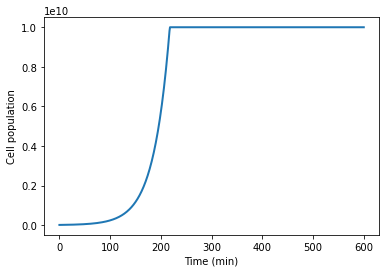

In [34]:
r = te.loada(model)
N = r.simulate(0, 600, 601, selections = ['time','N'])
te.plotArray(N, xlabel = 'Time (min)', ylabel = 'Cell population' )

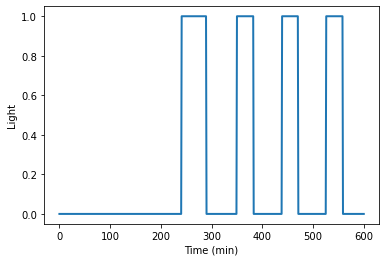

In [35]:
r = te.loada(model)
L = r.simulate(0, 600, 601, selections = ['time','light_on'])
te.plotArray(L, xlabel = 'Time (min)', ylabel = 'Light' )

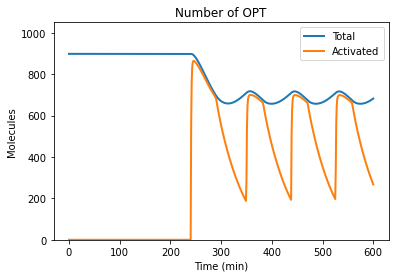

In [54]:
r = te.loada(model)
OPT = r.simulate(0, 600, 601, selections = ['time','OPT_tot', 'OPT_act'])
te.plotArray(OPT, xlabel = 'Time (min)', ylabel = 'Molecules', title = 'Number of OPT', labels = ['Total','Activated'], ylim =[0,1050])

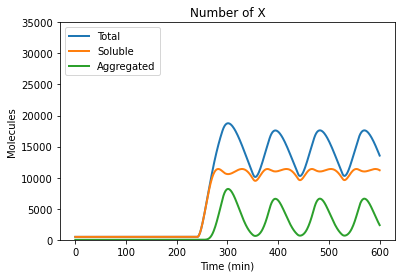

In [37]:
r = te.loada(model)
X = r.simulate(0, 600, 601, selections = ['time','X_tot','X_sol','X_agg'])
te.plotArray(X, xlabel = 'Time (min)', ylabel = 'Molecules', title = 'Number of X', labels = ["Total","Soluble","Aggregated"], loc = 'upper left', ylim = [0,35000] )

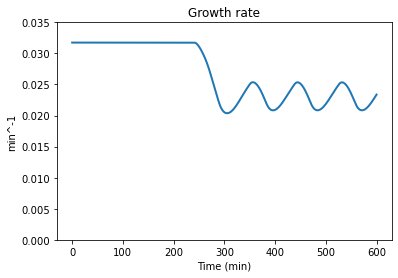

In [38]:
r = te.loada(model)
growth = r.simulate(0, 600, 601, selections = ['time','lmda'])
te.plotArray(growth, xlabel = 'Time (min)', ylabel = 'min^-1', title = 'Growth rate', ylim = [0,0.035])

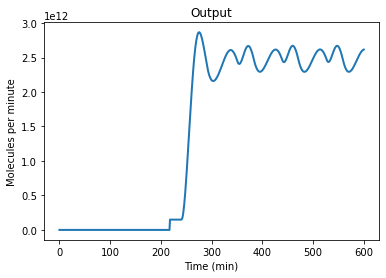

In [39]:
r = te.loada(model)
Output = r.simulate(0, 600, 601, selections = ['time','Output'])
te.plotArray(Output, xlabel = 'Time (min)', title = 'Output', ylabel = 'Molecules per minute' )

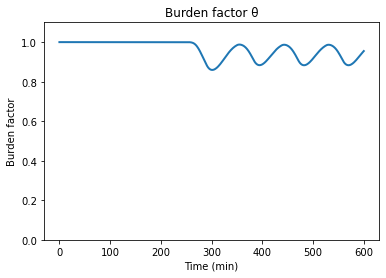

In [41]:
r = te.loada(model)
burden = r.simulate(0, 600, 601, selections = ['time', 'burden_factor'])
te.plotArray(burden, xlabel = 'Time (min)', ylabel = 'Burden factor', title = 'Burden factor θ', ylim = [0,1.1])

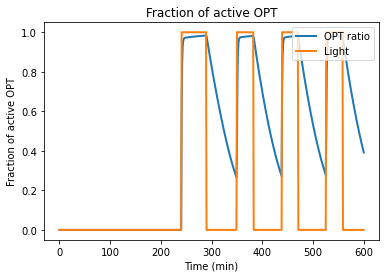

In [50]:
r = te.loada(model)
OPT = r.simulate(0, 600, 601, selections = ['time', 'OPT_ratio', 'light_on'])
te.plotArray(OPT, xlabel = 'Time (min)', ylabel = 'Fraction of active OPT', title = 'Fraction of active OPT', labels = ['OPT ratio', 'Light'])

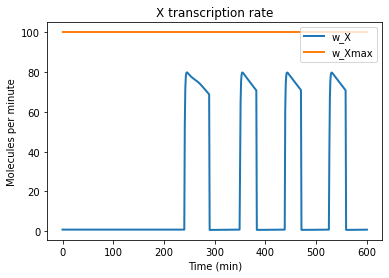

In [52]:
r = te.loada(model)
OPT = r.simulate(0, 600, 601, selections = ['time','w_X', 'w_Xmax'])
te.plotArray(OPT, xlabel = 'Time (min)', ylabel = 'Molecules per minute', title = 'X transcription rate', labels = ['w_X', 'w_Xmax'])